In [8]:
%pip install matplotlib
%pip install ipywidgets


[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached ipywidgets-8.1.1-py3-none-any.whl (139 kB)
  Using cached widgetsnbextension-4.0.9-py3-none-any.whl (2.3 MB)
  Using cached jupyterlab_widgets-3.0.9-py3-none-any.whl (214 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install raphtory

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Import necessary libraries
import pandas as pd

def preprocess_and_load_data(filepath):
    """
    Load and preprocess call graph data from a CSV file.
    
    This function performs several preprocessing steps on call graph data, including:
    1. Loading specific columns from the CSV file.
    2. Removing rows containing specific unwanted values.
    3. Handling missing values by removing rows with any NaN values.
    4. Ensures the 'timestamp' column is of type int64. (Otherwise Raphtory would throw the "Source and Target columns must be either u64 or text, Time column must be i64." error)
    
    The columns to be loaded and their respective data types are predefined within the function. The unwanted values that are to be removed are also predefined.
    
    Parameters:
    file_path (str): The path to the CSV file.
    
    Returns:
    pd.DataFrame: A pandas DataFrame containing the preprocessed call graph data.
    
    Note:
    The function assumes that the input CSV file adheres to a specific structure and contains specific columns. If the CSV file differs significantly from this expected structure, the function may not perform correctly.
    """

    # Define the columns that need to be loaded
    columns = ["timestamp", "um", "dm"]

    # Define data types for each column
    data_types = {
        "timestamp": int,
        "um": str,
        "dm": str,
    }

    # Load the data
    call_graph_df = pd.read_csv(filepath, usecols=columns, dtype=data_types)

    # Remove rows with unwanted values & Filter out rows that have any NaN values
    unwanted_values=["UNKNOWN", "UNAVAILABLE"]
    call_graph_df = call_graph_df[~call_graph_df.isin(unwanted_values).any(axis=1)].copy()
    call_graph_df = call_graph_df.dropna()

    # Ensure 'timestamp' column is int64
    call_graph_df['timestamp'] = call_graph_df['timestamp'].astype('int64')

    return call_graph_df

In [3]:
import os
import pandas as pd
from raphtory import Graph

base_filepath = 'c:/Users/maruf/Alibaba-CallGraph/CallGraph_{}.csv'
start_file_number = 0
end_file_number = 0

# Initialise an empty Raphtory graph
g = Graph()

for file_number in range(start_file_number, end_file_number + 1):
    filepath = base_filepath.format(file_number)
    if os.path.exists(filepath):
        # Preprocess the data and load into a DataFrame
        call_graph_df = preprocess_and_load_data(filepath)
        
        # Load the data from the DataFrame into the Raphtory graph
        g.load_edges_from_pandas(
            df=call_graph_df,
            src="um",
            dst="dm",
            time="timestamp",
        )
    else:
        print(f"File does not exist: {filepath}")

print(g)

Graph(number_of_edges=52772, number_of_vertices=17175, number_of_temporal_edges=10697316, earliest_time="0", latest_time="179999")


In [4]:

# Import necessary libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from raphtory import Graph

class ContactSequenceDiagram:
    def __init__(self, graph, earliest_time=None, latest_time=None, figsize=(12, 5), save_file=False, filename='Contact_Sequence.PNG'):
        self.graph = graph
        # Control file saving
        self.save_file = save_file
        # Set earliest_time and latest_time from graph if not provided
        if earliest_time is None:
            self.earliest_time = graph.earliest_time
        else:
            self.earliest_time = earliest_time
        if latest_time is None:
            self.latest_time = graph.latest_time
        else:
            self.latest_time = latest_time
        # Set a size of the diagram
        self.figsize = figsize
        # Name of the file, the user may change name and format of the file
        self.filename = filename
        # Choose a colour for a node using custom_palette
        self.node_colours = self.generate_colours()
        # Get indexes of nodes in graph
        self.y_positions = {node.name: i for i, node in enumerate(graph.vertices)}

    def generate_colours(self):
        """ 
        Generate random distinct colors for each node using custom_palette.
        """
        custom_palette = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231',
                          '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', 
                          '#ea476f', '#2f8d3b', '#fee74c', '#2748c0', '#f79f61',
                          '#b129db', '#75f3f3', '#f361eb', '#97c707', '#f68e8e']
        return {node.name: custom_palette[i % len(custom_palette)] for i, node in enumerate(self.graph.vertices)}

    def set_custom_x_ticks(self, max_value, interval=10):
        # Generate a list of tick positions, which is every integer from 0 to max_value
        all_ticks = list(range(max_value + 1))
        # Generate a list of labels, with labels only at the specified interval and empty strings for others
        labels = [str(i) if i % interval == 0 else '' for i in all_ticks]
        # Set the ticks on the x-axis to the all_ticks
        plt.xticks(ticks=all_ticks, labels=labels)
        # Set the x-axis limits to include a bit before the earliest time and a bit after the max_value
        plt.xlim(self.earliest_time - (interval/2.5), max_value + (interval/4))

    def plot_horizontal_line(self, node):
        """
        Plot a horizontal line for the node at the given y_position using the node's colour.
        """
        plt.hlines(self.y_positions[node], xmin=(self.earliest_time - 0.75), xmax=self.latest_time, 
                   colors=self.node_colours[node], linestyles='solid', lw=3.5, alpha=0.4)

    def plot_interaction(self, source, target, timestamps):
        """
        Plot an edge with a dot and a connecting line.
        edge.src and edge.dst are the node labels, time is the x position.
        All lines representing edges are in black colour.
        """
        for time in timestamps:
            # Plot a dot for the source node
            plt.plot(time, self.y_positions[source], 'o', color=self.node_colours[source], markersize=10)
            # Plot a dot for the target if different from the source
            if source != target:
                plt.plot(time, self.y_positions[target], 'o', color=self.node_colours[target], markersize=10)
                # Calculate the arc's lenght/height based on source and target positions
                arc_height = -0.2 if self.y_positions[source] < self.y_positions[target] else 0.2
                # Create a patch for the arc
                arc = mpatches.FancyArrowPatch((time, self.y_positions[source]), (time, self.y_positions[target]), 
                                                   connectionstyle=f"arc3,rad={arc_height}", color='black', lw=1)
                # Plot the arcs
                plt.gca().add_patch(arc)

    def setup_plot(self):
        """
        Initialize the plot with labels, axes, etc.
        """
        # Set a size of the diagram
        plt.figure(figsize=self.figsize)
        # Set a label on the x-axis
        plt.xlabel('Time')
        # Set the title
        plt.title('Schematic Contact Sequence')
        # Get rid of lines on the x-axis points
        plt.grid(False)

    def finalize_plot(self, ):
        """
        Display the plot and if fancy, save it to a file.
        """
        # Set the y-ticks to node labels
        plt.yticks(range(len(self.graph.vertices)), list(self.graph.vertices.name))
        # Call the custom function to set the x-ticks and labels
        self.set_custom_x_ticks(max_value=self.latest_time, interval=10)
        # Set the y-axis limits to include all nodes
        plt.ylim(-1, len(self.graph.vertices))
        plt.tight_layout()
        # Saves the plot as a file only if save_file is True
        if self.save_file:
            plt.savefig(self.filename)
        # Saves the plot as a file only if save_file is True
        if self.save_file:
            try:
                plt.savefig(self.filename)
                print(f"Diagram saved as {self.filename}")
            except Exception as e:
                print(f"Error saving file: {e}")
        # Display the diagram
        plt.show()

    def create_diagram(self, save_file=False):
        # Set up a save_file flag for finalize_plot() function
        if save_file is not False:
            self.save_file = save_file
        self.setup_plot()
        # Iterate over all vertices with their name
        for node in self.graph.vertices:
            self.plot_horizontal_line(node.name)
        # Iterate over edges with their full history of timestamps
        for edge in self.graph.edges:
            self.plot_interaction(edge.src.name, edge.dst.name, edge.history())
        self.finalize_plot()

In [ ]:
# Create and display the diagram
diagram = ContactSequenceDiagram(g, figsize=(32,15), save_file=True)
diagram.create_diagram()

In [ ]:
print(
    f"The full range of time in the graph is {g.earliest_time} to {g.latest_time}\n"
)

for expanding_g in g.expanding("10000"):
    print(
        f"From {expanding_g.start_time} to {expanding_g.end_time} there were {expanding_g.count_temporal_edges()} ms interactions"
    )

print()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

avg_degree = []
time = []

for windowed_graph in g.rolling(window=3000):
    result = rp.average_degree(windowed_graph)
    avg_degree.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, avg_degree)
plt.xlabel("Time Window")
plt.ylabel("Avg Degree")
plt.title("Alibaba's microservices average degree over time")
plt.grid(True)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

avg_degree = []
time = []

for windowed_graph in g.rolling(window=1000):
    result = rp.average_degree(windowed_graph)
    avg_degree.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, avg_degree)
plt.xlabel("Time Window")
plt.ylabel("Avg Degree")
plt.title("Alibaba's microservices average degree over time")
plt.grid(True)

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

avg_degree = []
time = []

for windowed_graph in g.rolling(window=100):
    result = rp.average_degree(windowed_graph)
    avg_degree.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, avg_degree)
plt.xlabel("Time Window")
plt.ylabel("Avg Degree")
plt.title("Alibaba's microservices average degree over time")
plt.grid(True)

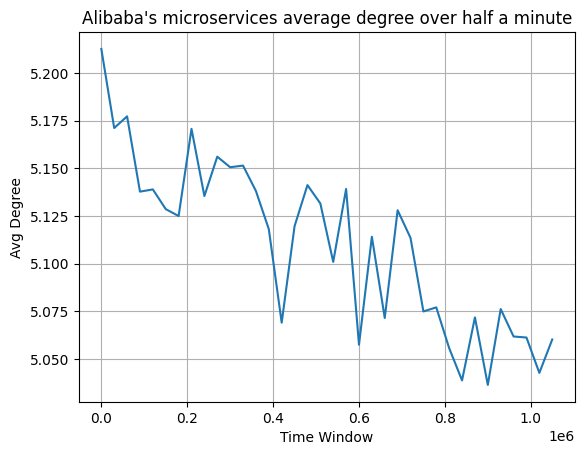

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

avg_degree = []
time = []

for windowed_graph in g.rolling(window=30000):
    result = rp.average_degree(windowed_graph)
    avg_degree.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, avg_degree)
plt.xlabel("Time Window")
plt.ylabel("Avg Degree")
plt.title("Alibaba's microservices average degree over half a minute")
plt.grid(True)

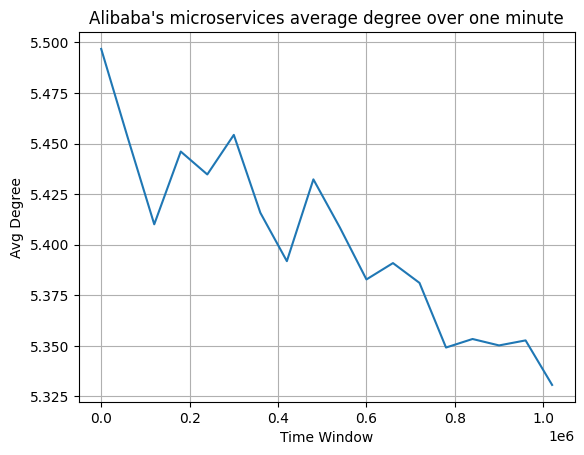

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

avg_degree = []
time = []

for windowed_graph in g.rolling(window=60000):
    result = rp.average_degree(windowed_graph)
    avg_degree.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, avg_degree)
plt.xlabel("Time Window")
plt.ylabel("Avg Degree")
plt.title("Alibaba's microservices average degree over one minute")
plt.grid(True)

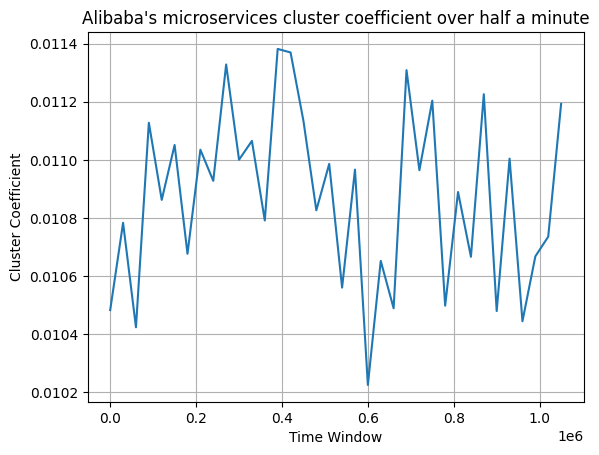

In [21]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

clstr_cfsnt = []
time = []

for windowed_graph in g.rolling(window=30000):
    result = rp.global_clustering_coefficient(windowed_graph)
    clstr_cfsnt.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, clstr_cfsnt)
plt.xlabel("Time Window")
plt.ylabel("Cluster Coefficient")
plt.title("Alibaba's microservices cluster coefficient over half a minute")
plt.grid(True)

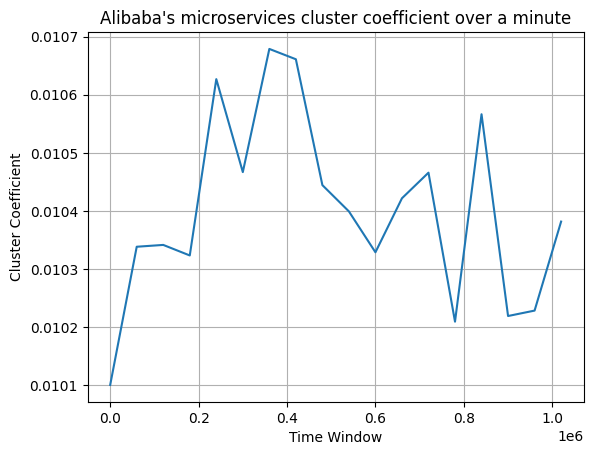

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

clstr_cfsnt = []
time = []

for windowed_graph in g.rolling(window=60000):
    result = rp.global_clustering_coefficient(windowed_graph)
    clstr_cfsnt.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, clstr_cfsnt)
plt.xlabel("Time Window")
plt.ylabel("Cluster Coefficient")
plt.title("Alibaba's microservices cluster coefficient over a minute")
plt.grid(True)

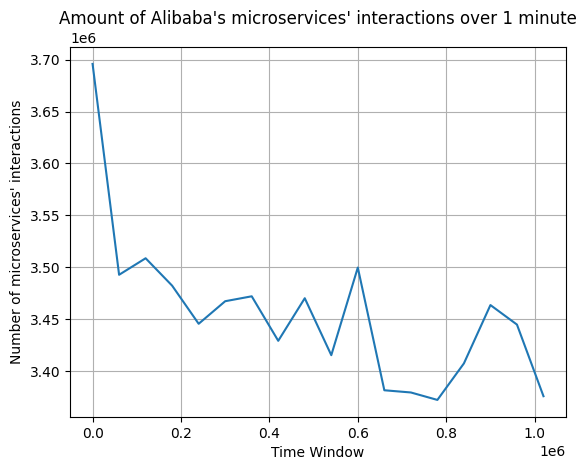

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

"""
Diagram which gives the number of microservices' interactions over time, in this case over one minute
"""

num_temp_edges = []
time = []

for windowed_graph in g.rolling(window=60000):
    result = windowed_graph.count_temporal_edges()
    num_temp_edges.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, num_temp_edges)
plt.xlabel("Time Window")
plt.ylabel("Number of microservices' interactions")
plt.title("Amount of Alibaba's microservices' interactions over 1 minute")
plt.grid(True)

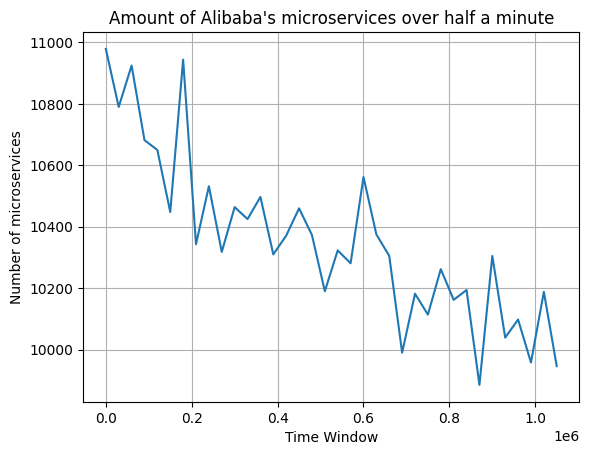

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

"""
Diagram which gives the number of microservices over time, in this case over 10000 microseconds
"""

num_nodes = []
time = []

for windowed_graph in g.rolling(window=30000):
    result = windowed_graph.count_vertices()
    num_nodes.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, num_nodes)
plt.xlabel("Time Window")
plt.ylabel("Number of microservices")
plt.title("Amount of Alibaba's microservices over half a minute")
plt.grid(True)

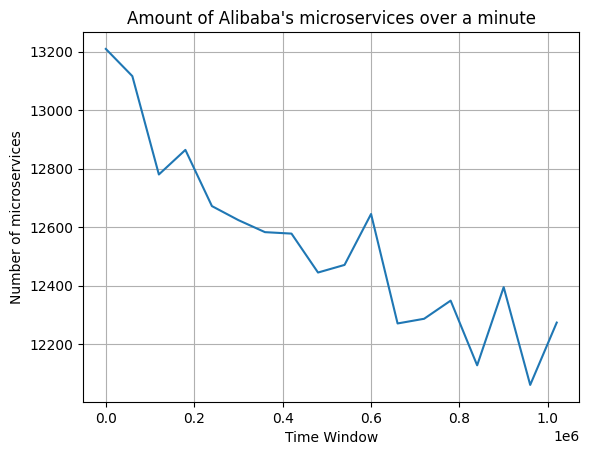

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

"""
Diagram which gives the number of microservices over time, in this case over 10000 microseconds
"""

num_nodes = []
time = []

for windowed_graph in g.rolling(window=60000):
    result = windowed_graph.count_vertices()
    num_nodes.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, num_nodes)
plt.xlabel("Time Window")
plt.ylabel("Number of microservices")
plt.title("Amount of Alibaba's microservices over a minute")
plt.grid(True)

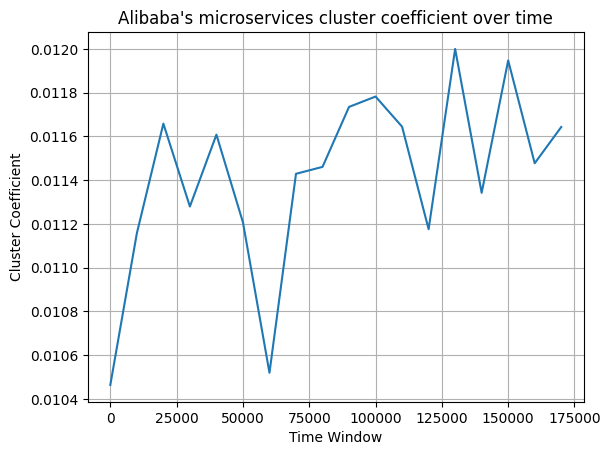

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

clstr_cfsnt = []
time = []

for windowed_graph in g.rolling(window=10000):
    result = rp.global_clustering_coefficient(windowed_graph)
    clstr_cfsnt.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, clstr_cfsnt)
plt.xlabel("Time Window")
plt.ylabel("Cluster Coefficient")
plt.title("Alibaba's microservices cluster coefficient over time")
plt.grid(True)

In [46]:
results = rp.global_clustering_coefficient(g)

top_5 = results.top_k(10)
for rank, (name,score) in enumerate(top_5, 1):
    print(f"Rank {rank}: {name} with a score of {score:.5f}")

AttributeError: 'float' object has no attribute 'top_k'

In [59]:
from raphtory import algorithms as rp
from raphtory import Graph

dd = rp.weakly_connected_components(g, 1000)
getall = results.get_all_with_names(dd)

AttributeError: 'float' object has no attribute 'get_all_with_names'

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

clstr_cfsnt = []
time = []

for windowed_graph in g.rolling(window=3000):
    result = rp.global_clustering_coefficient(windowed_graph)
    clstr_cfsnt.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, clstr_cfsnt)
plt.xlabel("Time Window")
plt.ylabel("Cluster Coefficient")
plt.title("Alibaba's microservices cluster coefficient over time")
plt.grid(True)

In [16]:
from raphtory import algorithms as rp

print(rp.max_degree(g))

2971


In [17]:
results = rp.pagerank(g)

top_5 = results.top_k(5)
for rank, (name,score) in enumerate(top_5, 1):
    print(f"Rank {rank}: {name} with a score of {score:.5f}")

Rank 1: MS_27421 with a score of 0.03206
Rank 2: MS_37691 with a score of 0.02028
Rank 3: MS_2827 with a score of 0.00770
Rank 4: MS_46825 with a score of 0.00529
Rank 5: MS_21883 with a score of 0.00366


In [24]:
'''
Filtering: top 5 microservices with the highest pagerank
'''

print(f"There are {g.count_vertices()} microservices in the whole graph")
subgraph = g.subgraph(["MS_27421", "MS_37691", "MS_2827", "MS_46825", "MS_21883"])
print(f"There are {subgraph.count_vertices()} microservices in the subgraph")
neighbours = g.vertex("MS_27421").neighbours.name.collect()
print(f"MS_27421 has the following neighbours in the full graph: {neighbours}")
neighbours = subgraph.vertex("MS_27421").neighbours.name.collect()
print(f"MS_27421 has the following neighbours in the subgraph: {neighbours}")

start_time = g.earliest_time
end_time = g.latest_time

neighbours = (
    subgraph.vertex("MS_27421").window(start_time, end_time).neighbours.name.collect()
)
print(
    f"MS_27421 has the following neighbours in the subgraph between {start_time} and {200}: {neighbours}"
)

There are 17175 microservices in the whole graph
There are 5 microservices in the subgraph
MS_27421 has the following neighbours in the full graph: ['MS_71712', 'MS_11245', 'MS_20664', 'MS_51052', 'MS_58423', 'MS_30021', 'MS_66857', 'MS_7226', 'MS_7932', 'MS_71771', 'MS_40147', 'MS_23429', 'MS_61034', 'MS_30935', 'MS_55394', 'MS_69188', 'MS_13558', 'MS_28911', 'MS_63630', 'MS_54287', 'MS_19960', 'MS_41516', 'MS_6379', 'MS_29370', 'MS_53254', 'MS_17703', 'MS_57945', 'MS_27021', 'MS_36669', 'MS_30441', 'MS_16399', 'MS_71888', 'MS_65112', 'MS_27283', 'MS_39620', 'MS_58940', 'MS_69876', 'MS_22184', 'MS_12238', 'MS_6845', 'MS_7766', 'MS_37711', 'MS_67564', 'MS_3199', 'MS_56159', 'MS_22973', 'MS_49081', 'MS_902', 'MS_43414', 'MS_14753', 'MS_16477', 'MS_15125', 'MS_43364', 'MS_503', 'MS_49109', 'MS_18327', 'MS_62108', 'MS_45335', 'MS_13994', 'MS_6142', 'MS_61676', 'MS_40088', 'MS_51980', 'MS_61055', 'MS_72189', 'MS_15549', 'MS_23530', 'MS_62157', 'MS_69708', 'MS_2515', 'MS_37831', 'MS_21740',

In [33]:
print(f"There are {g.count_vertices()} microservices in the whole graph")
subgraph = g.subgraph(["MS_27421", 'MS_45547', 'MS_15150', 'MS_52878', 'MS_18881', 'MS_13651', 'MS_3569', 'MS_15302', 'MS_50308', 
                       'MS_34713', 'MS_28026', 'MS_36114', 'MS_29805', 'MS_45541', 'MS_59238', 'MS_36678', 'MS_6015', 'MS_69505', 
                       'MS_22045', 'MS_52143', 'MS_57808', 'MS_2922', 'MS_69335', 'MS_7808', 'MS_58649', 'MS_38125', 'MS_311', 'MS_5991', 
                       'MS_44893', 'MS_49567', 'MS_23289', 'MS_65633', 'MS_60271', 'MS_18151', 'MS_64669', 'MS_10651', 'MS_55498', 'MS_35695', 
                       'MS_6635', 'MS_45645', 'MS_623', 'MS_43939', 'MS_26917', 'MS_61152', 'MS_2924', 'MS_58887', 'MS_63774', 'MS_24807', 'MS_24003', 
                       'MS_50339', 'MS_70888', 'MS_3627', 'MS_67697', 'MS_4793', 'MS_45375', 'MS_29778', 'MS_30918', 'MS_36143', 'MS_55701', 'MS_12251', 'MS_16643', 'MS_33550', 'MS_33073', 
                       'MS_24336', 'MS_53015', 'MS_16277', 'MS_69498', 'MS_9294', 'MS_33685', 'MS_27736', 'MS_32353', 'MS_29438', 
                       'MS_72072', 'MS_69098', 'MS_28586', 'MS_42085', 'MS_19743', 'MS_15274', 'MS_27104', 'MS_1153', 'MS_55082', 'MS_20499', 
                       'MS_10484', 'MS_22966', 'MS_61743', 'MS_17939'])
print(f"There are {subgraph.count_vertices()} microservices in the subgraph")
neighbours = g.vertex("MS_45547").neighbours.name.collect()
print(f"MS_45547 has the following neighbours in the full graph: {neighbours}")
neighbours = subgraph.vertex("MS_45547").neighbours.name.collect()
print(f"MS_45547 has the following neighbours in the subgraph: {neighbours}")

start_time = g.earliest_time
end_time = g.latest_time

neighbours = (
    subgraph.vertex("MS_45547").window(start_time, end_time).neighbours.name.collect()
)
print(
    f"MS_27421 has the following neighbours in the subgraph between {start_time} and {200}: {neighbours}"
)

There are 17175 microservices in the whole graph
There are 86 microservices in the subgraph
MS_45547 has the following neighbours in the full graph: ['MS_27421', 'MS_11810', 'MS_14704', 'MS_38158']
MS_45547 has the following neighbours in the subgraph: ['MS_27421']
MS_27421 has the following neighbours in the subgraph between 0 and 200: ['MS_27421']


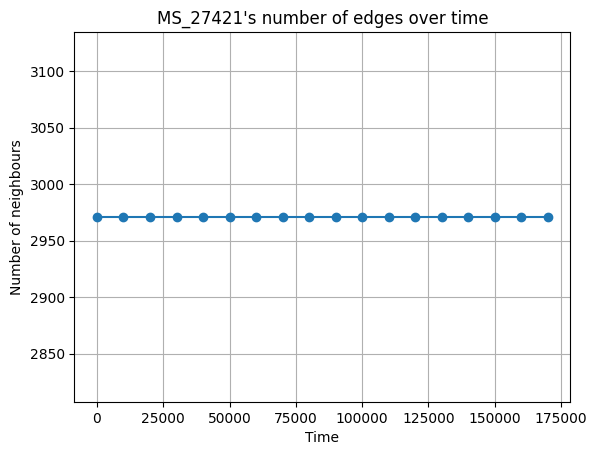

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

importance = []
time = []

for windowed_graph in g.rolling(window=10000):
    neighbours = g.vertex("MS_27421").neighbours.name.collect()
    result = len(neighbours)
    importance.append(result)
    time.append(windowed_graph.earliest_time)

plt.plot(time, importance, marker="o")
plt.xlabel("Time")
plt.ylabel("Number of neighbours")
plt.title("MS_27421's number of edges over time")
plt.grid(True)

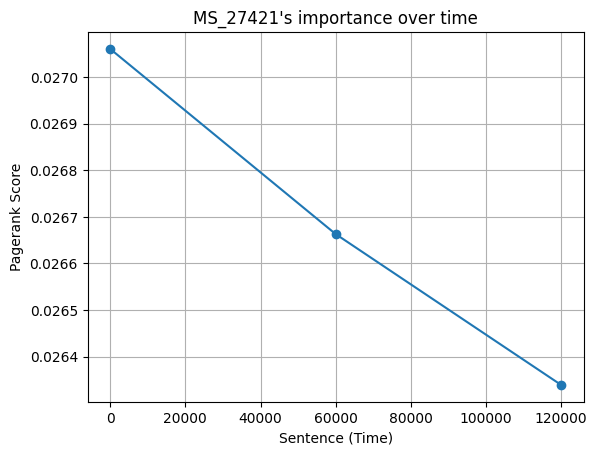

In [34]:
# mkdocs: render
import matplotlib.pyplot as plt
import pandas as pd
from raphtory import algorithms as rp
from raphtory import Graph

importance = []
time = []

for windowed_graph in g.rolling(window=60000):
    result = rp.pagerank(windowed_graph)
    importance.append(result.get("MS_27421"))
    time.append(windowed_graph.earliest_time)

plt.plot(time, importance, marker="o")
plt.xlabel("Sentence (Time)")
plt.ylabel("Pagerank Score")
plt.title("MS_27421's importance over time")
plt.grid(True)

In [ ]:
import os

# Save the file
absolute_save_path = os.path.abspath("saved_graph")
g.save_to_file(absolute_save_path)

# Load the file
if os.path.isfile(absolute_save_path):
    loaded_graph = Graph.load_from_file(absolute_save_path)
    print(loaded_graph)
else:
    print(f"File does not exist: {absolute_save_path}")

In [ ]:
import os
print("Current Working Directory:", os.getcwd())

In [ ]:
print(call_graph_df.dtypes)
print(call_graph_df.isnull().sum())
print(call_graph_df.isin([np.inf, -np.inf]).sum())

In [ ]:
import raphtory.export as ex
import json

pyvis_g = ex.to_pyvis(
    traffic_graph, edge_weight="data_size_MB", edge_color="#8e9b9e", directed=True
)

options = {
    "edges": {
        "scaling": {
            "min": 1,
            "max": 10,
        },
    },
    "physics": {
        "barnesHut": {
            "gravitationalConstant": -30000,
            "centralGravity": 0.3,
            "springLength": 100,
            "springConstant": 0.05,
        },
        "maxVelocity": 50,
        "timestep": 0.5,
    },
}

pyvis_g.set_options(json.dumps(options))

pyvis_g.show("nx.html")

In [7]:
map = {}

map = ("hello")
map = ("hi")

In [8]:
print(map)

hi


In [ ]:
prevMap[num] = i

In [9]:
thisdict = {
  "brand": "Ford",
  "model": "Mustang",
  "year": 1964
}
print(thisdict)

{'brand': 'Ford', 'model': 'Mustang', 'year': 1964}


In [15]:
for i, e in enumerate(thisdict):
    
    print(thisdict[e])

Ford
Mustang
1964
1


In [14]:
thisdict["Ford"] = 1

print(thisdict[e])

1964
